In [1]:
from datetime import datetime

import time
import os
import sys
from pathlib import Path

import numpy as np
from scipy.stats import lognorm
import pandas as pd

from astropy import stats
import astropy.units as u
from astropy.io import fits

import matplotlib
#matplotlib.use('nbagg')

from matplotlib import style
style.use("seaborn")
style.use('ggplot')
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
#%matplotlib widget

In [15]:
rootdir = Path("/mnt/f/wfsdat")
# use find to make this csv list
with open(rootdir / "all_seeing.txt") as f:
    csvs = f.readlines()

# loop through the csv files and read them with pandas
frames = []
for csv in csvs:
    frames.append(pd.read_csv(rootdir / csv.rstrip()))

# now concat each frame into one big frame containing all of the data
data = pd.concat(frames)

In [16]:
g = data.groupby('wfs')
g.wfs.describe()

,count,unique,top,freq
wfs,,,,
binospec,102020,1,binospec,102020
f5,98774,1,f5,98774
mmirs,81270,1,mmirs,81270
newf9,3047,1,newf9,3047
oldf9,55728,1,oldf9,55728


In [68]:
# re-calculate the seeing using updated spot FWHM for binospec. filter out any NaN values...
#fixed_list = []
#for wfskey, group in g:
#    wfs = wfs_systems[wfskey]
#    group = g.get_group(wfskey)
#    #group.apply(seeing, axis=1, args=(wfs,))
#    group['fixed_raw_seeing'], group['fixed_seeing'] = seeing(group, wfs)
#    fixed_list.append(group)
#fixed = pd.concat(fixed_list)
#fixed.rename(index=str, columns={"seeing": "orig_seeing", "raw seeing": "orig_raw_seeing"}, inplace=True)
#fixed.rename(index=str, columns={"fixed_seeing": "seeing", "fixed_raw_seeing": "raw seeing"}, inplace=True)
#data['seeing'][data['seeing'].apply(isinstance, args=(str,))] = 0.0
fixed = data[[isinstance(x, float) for x in data['seeing']]]
fixed['seeing'] = fixed['seeing'].astype(float)
fixed = fixed[np.isfinite(fixed['seeing'])]
fixed = fixed[fixed['fwhm'] > 0.]
fixed = fixed[fixed['seeing'] > 0.2]
fixed = fixed[fixed['seeing'] < 4.]
fixed = fixed[np.isfinite(fixed['airmass'])]
#fixed = fixed[fixed['time'] < "2020-12-31"]

<ipython-input-68-df6c348c280e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fixed['seeing'] = fixed['seeing'].astype(float)


In [69]:
fixed.sort_values(by='time')

,time,wfs,file,exptime,airmass,az,el,osst,outt,chamt,...,focerr,cc_x_err,cc_y_err,xcen,ycen,seeing,raw_seeing,fwhm,wavefront_rms,residual_rms
135,2003-04-11T04:46:44,oldf9,20030410_start_0001.fits,20.0,1.0600,177.889000,70.693000,NaN,NaN,NaN,...,9.25,0.000,-0.000,260.015521,267.004039,0.977057,0.977057,7.205232,765.359307,3561.538896
136,2003-04-11T04:47:06,oldf9,20030410_start_0002.fits,20.0,1.0600,178.162000,70.696000,NaN,NaN,NaN,...,2.05,0.000,-0.000,259.989181,266.980205,1.005677,1.005677,7.352807,775.887303,3529.074509
137,2003-04-11T04:47:27,oldf9,20030410_start_0003.fits,20.0,1.0600,178.427000,70.699000,NaN,NaN,NaN,...,2.36,0.000,-0.622,260.020751,266.977415,0.999719,0.999719,7.322095,755.812601,3515.532334
138,2003-04-11T04:52:40,oldf9,20030410_start_cor_0000.fits,20.0,1.0600,182.299000,70.698000,NaN,NaN,NaN,...,-39.19,0.000,-0.000,257.009320,269.976762,0.770863,0.770863,6.139361,1125.153415,3372.555244
139,2003-04-11T04:55:15,oldf9,20030410_start_cor_0001.fits,20.0,1.0600,184.205000,70.670000,NaN,NaN,NaN,...,17.41,-0.000,-0.000,254.984789,273.000265,0.754799,0.754799,6.056333,665.754486,3364.324103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
712,2021-04-08T11:52:54.858000,binospec,wfs_ff_cal_img_2021.0408.115254.fits,40.0,1.3239,316.166560,49.053621,9.28,9.4,9.206,...,0.00,-1.703,0.000,276.012870,248.986231,1.736434,2.054809,9.243360,240.598424,1230.950963
713,2021-04-08T11:53:38.102000,binospec,wfs_ff_cal_img_2021.0408.115338.fits,40.0,1.3261,316.134384,48.948103,9.25,9.4,9.096,...,-1.74,-0.955,0.000,276.993555,249.013150,1.593198,1.887189,8.629781,191.618679,1416.264337
714,2021-04-08T11:54:21.338000,binospec,wfs_ff_cal_img_2021.0408.115421.fits,40.0,1.3282,316.102874,48.841662,9.28,9.3,9.094,...,-0.76,-1.401,0.000,277.008188,248.988648,1.868889,2.215856,9.826204,247.771417,1075.100371
715,2021-04-08T11:55:04.579000,binospec,wfs_ff_cal_img_2021.0408.115504.fits,40.0,1.3304,316.072393,48.733548,9.32,9.3,9.173,...,0.00,-1.526,0.000,277.983364,248.016150,1.640075,1.946494,8.847711,165.648747,1274.331863


In [70]:
# create a date-time index so we can group and analyze the data by timestamps
fixed = fixed.set_index(pd.DatetimeIndex(fixed['time'], name='ut'))

In [71]:
fixed['seeing'].median()

0.9876331613731486

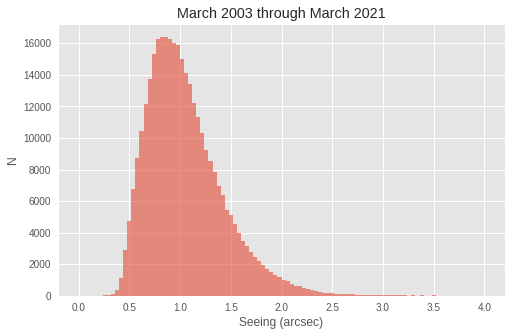

In [72]:
# make raw histogram of the zenith-corrected seeing column
#fixed.hist(column='seeing', bins=100, range=(0.0, 4.0), alpha=0.6)
with plt.style.context('ggplot'):
    fig = plt.figure(figsize=(8, 5))
    plt.hist(fixed['seeing'], bins=100, range=(0.0, 4.), alpha=0.6)
    plt.title("March 2003 through March 2021")
    plt.xlabel("Seeing (arcsec)")
    plt.ylabel("N")
plt.show()

In [73]:
np.array(fixed['seeing'], dtype=float)

array([0.37009125, 1.76657534, 1.80762681, ..., 1.86888882, 1.64007536,
       1.62574008])

In [74]:
# fit a log-normal distribution to the seeing data
seeing = np.array(fixed['seeing'], dtype=float)
sigma, loc, exp_mu = lognorm.fit(seeing)
print(sigma, loc, exp_mu)
x = np.arange(0.0, 4.0, 0.01)
p = lognorm.pdf(x, sigma, loc=loc, scale=exp_mu)
mu = np.log(exp_mu)
mode = np.exp(mu - sigma**2) + loc
median = np.median(seeing)
fit_median = exp_mu + loc

0.38920996857787016 0.10144394915770152 0.8835798174333644


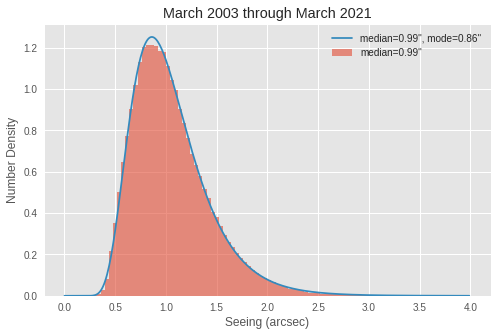

In [75]:
# plot normalized histogram with the fit and the median/mode calculated from the fit.
fig = plt.figure(figsize=(8, 5))
with plt.style.context('ggplot'):
    plt.hist(fixed['seeing'], density=True, bins=100, range=(0.0, 4.0), label="hist", alpha=0.6)
    logp = plt.plot(x, p, label="logp")
    plt.xlabel("Seeing (arcsec)")
    plt.ylabel("Number Density")
    plt.title("March 2003 through March 2021")
    plt.legend(["median=%.2f\", mode=%.2f\"" % (fit_median, mode), "median=%.2f\"" % (
        median
    )])
    plt.savefig("all_hist.png")
plt.show()

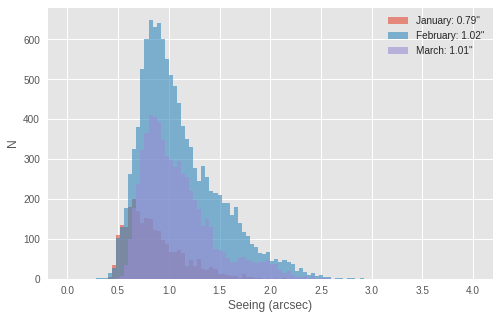

In [76]:
# panda time indexing makes it easy to group by month
fig = plt.figure(figsize=(8, 5))
months = {}
legends = []
months['January'] = fixed.loc['2021-01']
months['February'] = fixed.loc['2021-02']
months['March'] = fixed.loc['2021-03']
for m in months:
    plt.hist(months[m]['seeing'], bins=100, range=(0.0, 4.0), label=m, alpha=0.6)
    legend = "%s: %.2f\"" % (m, np.median(months[m]['seeing']))
    legends.append(legend)
plt.legend(legends)
plt.xlabel("Seeing (arcsec)")
plt.ylabel("N")
#plt.title("Data and median seeing values grouped by month")
plt.savefig("all_monthly.png")
plt.show()

In [77]:
len(months['January']), len(months['February']), len(months['March'])

(2451, 11657, 6388)

In [78]:
# now use the between_time() method to split the data into first and second halves of the night.
first_half = fixed.between_time(start_time='00:00', end_time='07:00')
second_half = fixed.between_time(start_time='07:00', end_time='14:00')
#first_half = months['December'].between_time(start_time='00:00', end_time='07:00')
#second_half = months['December'].between_time(start_time='07:00', end_time='14:00')
med_1st = np.median(first_half['seeing'])
med_2nd = np.median(second_half['seeing'])

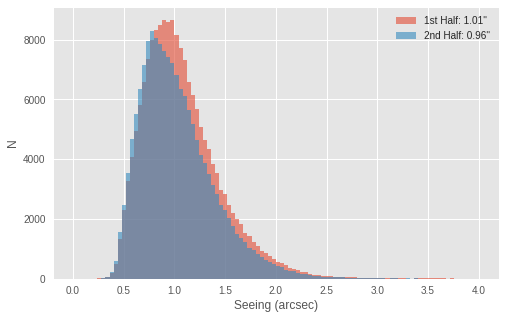

In [79]:
# plot the results and show that the seeing is better later in the night...
fig = plt.figure(figsize=(8, 5))
plt.hist(first_half['seeing'], bins=100, range=(0.0, 4.0), label="1st", alpha=0.6)
plt.hist(second_half['seeing'], bins=100, range=(0.0, 4.0), label="2nd", alpha=0.6)
plt.legend(["1st Half: %.2f\"" % med_1st, "2nd Half: %.2f\"" % med_2nd])
plt.xlabel("Seeing (arcsec)")
plt.ylabel("N")
#plt.title("Data and median seeing values grouped by half of the night")
plt.savefig("all_1st2nd.png")
plt.show()

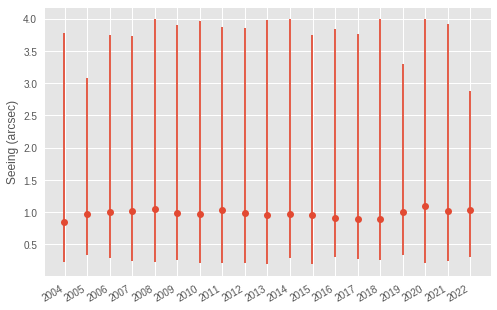

In [91]:
import matplotlib.dates as mdates

# make a new data frame that resamples the WFS data daily into the median, min, and max seeing for each day.
#fixed = fixed["2018-06-30":"2018-10-01"]
fig, ax = plt.subplots()
monthly = pd.DataFrame()
monthly['seeing'] = fixed.seeing.resample('Y').median()
monthly['max'] = fixed.seeing.resample('Y').max()
monthly['min'] = fixed.seeing.resample('Y').min()
lowb = monthly['seeing'] - monthly['min']
upb = monthly['max'] - monthly['seeing']
plt.errorbar(monthly.index, monthly['seeing'], yerr=[lowb, upb], fmt='o')
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
fig.autofmt_xdate()
plt.ylabel("Seeing (arcsec)")
#plt.title("Nightly median seeing")
plt.savefig("all_nightly.png")
plt.show()

In [116]:
month_list = list(monthly.index.strftime('%Y'))
data = [np.array(fixed.loc[month]['seeing']) for month in month_list]
clean_data = {}
for d, arr in zip(month_list, data):
    if len(arr) > 0:
        clean_data[d] = arr
month_labels = [datetime.strptime(d, "%Y").date() for d in clean_data.keys()]
sizes = [len(clean_data[y]) for y in clean_data]

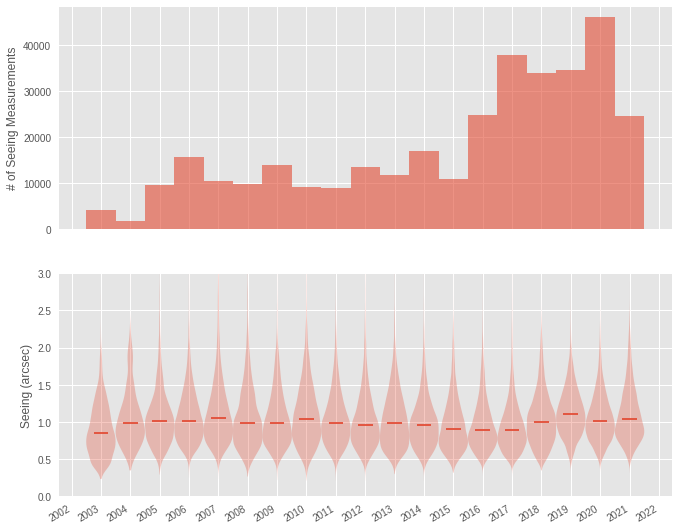

In [123]:
fig, ax = plt.subplots(2, figsize=(11,10), sharex=True)
ax[0].bar(mdates.date2num(month_labels), sizes, width=365, alpha=0.6)
ax[0].set_ylabel("# of Seeing Measurements")
ax[1].violinplot(clean_data.values(), mdates.date2num(month_labels), points=100, widths=365,
               showextrema=False, showmedians=True, bw_method='silverman')

ax[1].xaxis.set_major_locator(mdates.YearLocator())
ax[1].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
fig.autofmt_xdate()
ax[1].set_ylim(0.0, 3.0)
ax[1].set_ylabel("Seeing (arcsec)")
plt.savefig("all_violin.png")
plt.show()

In [112]:
for y in clean_data:
    print(f"{y}: {len(clean_data[y])}")

2003: 4157
2004: 1751
2005: 9491
2006: 15561
2007: 10326
2008: 9686
2009: 13914
2010: 9217
2011: 8842
2012: 13509
2013: 11768
2014: 16896
2015: 10823
2016: 24738
2017: 37888
2018: 33842
2019: 34695
2020: 46168
2021: 24495


In [115]:
[len(clean_data[y]) for y in clean_data]

[4157,
 1751,
 9491,
 15561,
 10326,
 9686,
 13914,
 9217,
 8842,
 13509,
 11768,
 16896,
 10823,
 24738,
 37888,
 33842,
 34695,
 46168,
 24495]